In [1]:
# !pip install -qqq timm
# import timm
# all_densenet_models = timm.list_models('*resnet*')
# all_densenet_models
# 18, 34, 50, 101, 200
import gc
import os
import pickle
import random
import re
import warnings
from collections import Counter
from random import randint

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import cifar10
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train = x_train[:10000]
# y_train = y_train[:10000]

2024-04-07 13:58:50.331074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 13:58:50.331168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 13:58:50.462716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [2]:


# Define the folder to store the dataset
folder_path_train = '/content/cifar10_dataset/train'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path_train):
    os.makedirs(folder_path_train)

# Save the training images
for i in range(len(x_train)):
    image_path = os.path.join(folder_path_train, f'train_{i}.png')
    tf.keras.preprocessing.image.save_img(image_path, x_train[i])

# # Save the testing images
# for i in range(len(x_test)):
#     image_path = os.path.join(folder_path, f'test_{i}.png')
#     tf.keras.preprocessing.image.save_img(image_path, x_test[i])

print(f'CIFAR-100 train dataset downloaded and stored in {folder_path_train}')

len(x_train)

def load_model(model_name):
    if('vit' in model_name):
      model = timm.create_model(model_name, pretrained=True, num_classes=0,)  # removes classifier nn.Linear)
    elif('vgg' in model_name):
      model = timm.create_model(model_name, pretrained=True, features_only=True,)
    else:
      model = timm.create_model(model_name, pretrained=True)
      model = torch.nn.Sequential(*list(model.children())[:-1])
    model = model.to(device)  # Move model to device
    model.eval()
    return model

# Modify load_image function to move the image tensor to the device
def load_image(file):
    img = Image.open(file)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = preprocess(img)

    # img = transforms.ToTensor()(img)  # Convert image to tensor
    img = img.unsqueeze(0)
    return img.to(device)  # Move image to device

# Modify extract_features function to move the features tensor to the CPU for numpy conversion
def extract_features(file, model, model_name):
    with torch.no_grad():
        # if('vitsknfnskfsk' in model_name):
        #   img = Image.open(file)
        #   data_config = timm.data.resolve_model_data_config(model)
        #   transforms = timm.data.create_transform(**data_config, is_training=False)
        #   # features = model.forward_features(transforms(img).unsqueeze(0))
        #   output = model(transforms(img).unsqueeze(0))
        #   # features = model.forward_features(img, is_training=False)

        # else:
          img = load_image(file)
          features = model(img)
    features = features.squeeze().cpu().numpy()  # Move features to CPU for numpy conversion
    return features

def extract_features_all(model_name, subset_size=None):
    model = load_model(model_name)

    # Use either all the data or a subset based on the subset_size argument
    if subset_size is not None:
        categories_subset = np.random.choice(categories, size=subset_size, replace=False)
    else:
        categories_subset = categories

    # Extract features for each image
    all_features = []
    counter = 0

    # Add tqdm to the loop for a progress bar
    for category in tqdm(categories_subset, desc="Extracting features"):
        file = os.path.join(path, category)
        features = extract_features(file, model, model_name)
        all_features.append(features)
        counter += 1

        # Call gc.collect() after every 10000 iterations
        if counter % 10000 == 0:
            gc.collect()

    # Save features to a file
    with open(f"{model_name}_features.pkl", 'wb') as f:
        pickle.dump(all_features, f)

    print(f"Successfully extracted features with {model_name}")

    return all_features, categories_subset


def view_clusters(groups):
# Function to view a cluster based on identifier
  def view_cluster(cluster):
    plt.figure(figsize=(25, 25))
    files = groups[cluster]
    if len(files) > 30:
      print(f"Clipping cluster size from {len(files)} to 30")
      files = files[:30]
    for index, file in enumerate(files):
      plt.subplot(10, 10, index + 1)
      img = cv2.imread(file)  # Load image using OpenCV
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      plt.imshow(img)
      plt.axis('off')

  # Visualize each cluster with a gap between them
  for cl_index, cl in enumerate(groups):
    view_cluster(cl)
    if cl_index != len(groups) - 1:  # Add a gap between clusters
      plt.figure()  # Create a new figure for the next cluster

def novel_class_detection(features, filenames, labels, x=2):
  K = 1
  Nnew = 0
  all_clusters = []
  tot_anotations_kmeans = 0
  annotated_images = []
  while Nnew >= K // 2:
    # Perform K-Means Clustering on features
    kmeans = KMeans(n_clusters=K,  n_init='auto', random_state=42)
    kmeans.fit(features)

    # Annotate x points from each cluster
    #choose x*K indices randomly from labels
    N_set = set()
    clusters = {}
    for file, cluster in zip(filenames, kmeans.labels_):
      if cluster not in clusters.keys():
        clusters[cluster] = []
      clusters[cluster].append(file)

    for ci in clusters:
      image_path_list = clusters[ci]
      images = random.sample(image_path_list, x)
      annotated_images+=images
      image_id = [int(re.search(r'\d+', filename).group()) for filename in images]
#       print(image_id)
#       for j in image_id:
#         print(j)
#         print(labels)
#         print(labels[j])
#       actual_labels.append(labels[j])
      actual_labels = [labels[i] for i in image_id]
      N_set.update(set(actual_labels))
      tot_anotations_kmeans+=x
    #check the acutal label -> get the number of distinct actual labels(N)
    N = len(N_set)
    #increment nnew by N-K
    Nnew += N-K

    # Double the value of K for the next iteration
    K *= 2

    #debug printing
    print("K:", K)
    print("Nnew:", Nnew)
  # Organize images into clusters
  clusters = {}
  for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in clusters.keys():
      clusters[cluster] = []
    clusters[cluster].append(file)

  return clusters, tot_anotations_kmeans, K, annotated_images

def process_clusters(clusters, tot_anotations, K, annotated_images, n_bad_clusters, labels):
    cluster_errs = {}
    cluster_labels = {}

    # for each cluster ci
    for idx, ci in enumerate(clusters):
        # for each image in ci: images are values in the dictionary
        image_path_list = clusters[ci]
        # pick p random images from image_path_list
        p_annotated_images = random.sample(image_path_list, p)
        annotated_images += p_annotated_images

        # get the actual labels for the images stored in a list
        image_id = [int(re.search(r'\d+', filename).group()) for filename in p_annotated_images]
        
        actual_labels = [labels[i][0] for i in image_id]

        # count the actual labels and get the max count
        counter = Counter(actual_labels)
        most_common_elements = counter.most_common()
        max_count = most_common_elements[0][1]
        cluster_label = most_common_elements[0][0]
        cluster_labels[idx] = cluster_label
        cluster_error = p - max_count
        cluster_errs[idx] = cluster_error
        tot_anotations += p

    # sort the cluster_errs dictionary by the values
    sorted_cluster_errs = sorted(cluster_errs.items(), key=lambda x: x[1], reverse=True)

    n_bad_clusters = min(n_bad_clusters, len(clusters))
    # pick the n_bad_clusters clusters with the highest error
    bad_clusters = sorted_cluster_errs[:n_bad_clusters]
    good_clusters = sorted_cluster_errs[n_bad_clusters:]

    # for each bad_cluster, pick q random images and annotate them
    for i, err in bad_clusters:
        image_path_list = clusters[i]
        q_annotated_images = random.sample(image_path_list, q)
        tot_anotations += q
        annotated_images += q_annotated_images

    return tot_anotations, annotated_images, cluster_errs, cluster_labels, bad_clusters, good_clusters

#train a model on the initial labelled data
#get confidence score(CS) for each point
#for a point if CS>threshold1 and point in Good Cluster and avg cosine similarity w. already annotated data points in cluster > threshold2
  #label the point as the cluster label <- Silver Labelling Strategy

def silver_annotate(threshold1=-2, threshold2=0.5):
    silver_annotation = {}
    # Use tqdm.notebook.tqdm to iterate over the items with a progress bar
    for k, v in tqdm(good_clusters, desc="Processing clusters", total=len(good_clusters)):
        # Your existing code goes here
        cluster_label = cluster_labels[k]
        clusteri = clusters[k]
        for curr_img_path in tqdm(clusteri, desc="silver annotating cluster", total=len(clusteri)):
            if curr_img_path in annotated_images:
                continue
            img = Image.open(curr_img_path).convert('RGB')
            img = transform(img)
            img = img.unsqueeze(0)
            img = img.to(device)
            output = model(img)
            confidences = np.squeeze(output.detach().cpu().numpy())
            predicted_class = np.argmax(confidences)
            top_confidence = confidences[predicted_class]

            #get the image paths of annotated_imgs_w_labels having label cluster_label
            annotated_img_paths = [img_path for img_path in annotated_imgs_w_labels if annotated_imgs_w_labels[img_path] == cluster_label]
            #get the index of the current image and the annotated images using the categories_subset
            curr_img_index = categories_subset.index(curr_img_path)
            annotated_img_indices = [categories_subset.index(img_path) for img_path in annotated_img_paths]
            # get the features of the current image and the annotated images
            curr_img_features = feat[curr_img_index]
            annotated_img_features = [feat[i] for i in annotated_img_indices]
            # get the cosine similarity of the current image with the annotated images
            similarities = []

            # Convert NumPy arrays to PyTorch tensors
            curr_img_features_tensor = torch.tensor(curr_img_features)
            # Reshape the tensor to be 2D with a single row
            curr_img_features_tensor = curr_img_features_tensor.reshape(1, -1)
            for features in annotated_img_features:
                features_tensor = torch.tensor(features)
                # Reshape the tensor to be 2D with a single row
                features_tensor = features_tensor.reshape(1, -1)
                similarity = F.cosine_similarity(curr_img_features_tensor, features_tensor).item()
                similarities.append(similarity)
            avg_similarity = np.mean(similarities)
#             print(top_confidence, avg_similarity)
            if top_confidence > threshold1 and avg_similarity > threshold2:
                silver_annotation[curr_img_path] = cluster_label
    return silver_annotation

CIFAR-100 train dataset downloaded and stored in /content/cifar10_dataset/train


In [3]:
"""# Resnet"""

# if __name__ == "__main__":
# (_, _), (_, labels) = cifar10.load_data()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = "/content/cifar10_dataset/train"
os.chdir(path)

# This list holds all the image filenames
categories = []

# Creates a list of image filenames
with os.scandir(folder_path_train) as files:
    for file in files:
        if file.name.endswith('.png'):
            categories.append(file.name)

model_name = 'resnet101'
feature_extraction_model_name = 'resnet101'
# model_name = 'vit_base_patch16_224'
# feature_extraction_model_name = 'vit_base_patch16_224'
# subset_size = 200  # Change this to the desired subset size, or None to use all the data
# feat, categories_subset = extract_features_all(model_name, 30000)
feat, categories_subset = extract_features_all(feature_extraction_model_name)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Extracting features:   0%|          | 0/50000 [00:00<?, ?it/s]

Successfully extracted features with resnet101


In [4]:
# Dictionary to store the mapping of filenames to labels
label_mapping = {}

# Iterate over each filename in categories_subset and its corresponding label
for i in range(len(categories_subset)):
    filename = categories_subset[i]
    label = y_train[i][0]
    label_mapping[filename] = label

label_mapping

numbers = [int(re.search(r'\d+', filename).group()) for filename in categories_subset]
label_subset = [y_train[i][0] for i in numbers]


# x = ___
p = 40
q = 30
n_bad_clusters = 3

threshold1 = -2   # confidence threshold: -2
threshold2 = 0.1  # avg coisne similarity threshold

In [5]:
clusters, tot_anotations, K, annotated_images = novel_class_detection(feat, categories_subset, label_subset)

tot_anotations, annotated_images, cluster_errs, cluster_labels, bad_clusters, good_clusters = process_clusters(clusters, tot_anotations, K, annotated_images, n_bad_clusters, y_train)

# print(tot_anotations, "\n", sorted_cluster_errs)
print(tot_anotations)
print("Good clusters: ", good_clusters, "\nBad clusters: ", bad_clusters)
print(cluster_labels)

#annotated images and labels
image_id = [int(re.search(r'\d+', filename).group()) for filename in annotated_images]
annotated_imgs_w_labels = {annotated_images[i]:y_train[idx][0] for i, idx in enumerate(image_id)}
annotated_labels = [y_train[i][0] for i in image_id]
# annotated_imgs_w_labels
# annotated_labels

# Step 1: Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # print("Debug:", img_path)
        label = self.labels[img_path]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Step 2: Define transforms and create DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(image_paths=annotated_images, labels=annotated_imgs_w_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Step 3: Define the ResNet model architecture
num_classes = len(set(annotated_imgs_w_labels.values())) #10  # Assuming you have 10 classes
model = timm.create_model(model_name, pretrained=True)

if 'vit' in model_name:
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, num_classes)
else:   
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

# Step 4: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 5: Fine-tune the model
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
#         print(outputs)
#         print(labels)
#         break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print('Finished Training')


silver_annotation = silver_annotate()

silver_annotation

# Group keys by their corresponding values into a new dictionary
grouped_dict = {}
for key, value in silver_annotation.items():
    grouped_dict.setdefault(value, []).append(key)

# Convert the dictionary values to lists
grouped_lists = grouped_dict

# print(grouped_lists)

# gc.collect()

# view_clusters(clusters)

K: 2
Nnew: 1
K: 4
Nnew: 3
K: 8
Nnew: 5
K: 16
Nnew: 6
440
Good clusters:  [(6, 19), (4, 13), (7, 7), (0, 6), (1, 0)] 
Bad clusters:  [(3, 23), (2, 22), (5, 20)]
{0: 9, 1: 1, 2: 7, 3: 0, 4: 8, 5: 6, 6: 3, 7: 5}
Epoch [1/20], Loss: 2.1186
Epoch [2/20], Loss: 1.9579
Epoch [3/20], Loss: 1.7375
Epoch [4/20], Loss: 1.5884
Epoch [5/20], Loss: 1.5369
Epoch [6/20], Loss: 1.4203
Epoch [7/20], Loss: 1.3917
Epoch [8/20], Loss: 1.1482
Epoch [9/20], Loss: 0.8599
Epoch [10/20], Loss: 0.7389
Epoch [11/20], Loss: 0.5347
Epoch [12/20], Loss: 0.4177
Epoch [13/20], Loss: 0.5597
Epoch [14/20], Loss: 0.5172
Epoch [15/20], Loss: 0.4630
Epoch [16/20], Loss: 0.3625
Epoch [17/20], Loss: 0.4443
Epoch [18/20], Loss: 0.2683
Epoch [19/20], Loss: 0.1805
Epoch [20/20], Loss: 0.1550
Finished Training


Processing clusters:   0%|          | 0/5 [00:00<?, ?it/s]

silver annotating cluster:   0%|          | 0/4766 [00:00<?, ?it/s]

silver annotating cluster:   0%|          | 0/9271 [00:00<?, ?it/s]

silver annotating cluster:   0%|          | 0/8394 [00:00<?, ?it/s]

silver annotating cluster:   0%|          | 0/5772 [00:00<?, ?it/s]

silver annotating cluster:   0%|          | 0/6459 [00:00<?, ?it/s]

In [6]:
# view_clusters(grouped_lists)

In [7]:
len(silver_annotation)

132

In [8]:
good_clusters_cpy = good_clusters
bad_clusters_cpy = bad_clusters

In [9]:

def gold_annotate(model, annotated_images, labels, clusters, good_clusters, bad_clusters, budget):
    # Get confidence scores for all unannotated images in the clusters
    all_confidences = {}
    for cluster, image_paths in clusters.items():
        for image_path in image_paths:
            if image_path in annotated_images:
                continue
            img = Image.open(image_path).convert('RGB')
            img = transform(img)
            img = img.unsqueeze(0)
            img = img.to(device)
            output = model(img)
            confidences = np.squeeze(output.detach().cpu().numpy())
            all_confidences[image_path] = np.max(confidences)

    # Sort image paths by their confidence scores from lowest to highest
    sorted_confidences = sorted(all_confidences.items(), key=lambda x: x[1])

    gold_annotations = {}
    remaining_budget = budget
    
    bad_cluster_images = []
#     print(clusters)
#     print(50*'*')
    for cluster_idx, _ in bad_clusters:
#         print(cluster_idx)
#         print(50*'*')
#         print(clusters[cluster_idx])
        bad_cluster_images.extend(clusters[cluster_idx])
#             cluster_images = clusters[cluster_idx]
#     print(50*'*')

#     print(bad_cluster_images)
#     print(50*'*')
    # Annotate low confidence images, prioritizing bad clusters
    for image_path, _ in sorted_confidences:
#         print(image_path)
        if remaining_budget <= 0:
            break

        if image_path in annotated_images or image_path in gold_annotations:
            continue
        

#         cluster_images = None
#         if bad_clusters:
#             cluster_idx, _ = bad_clusters.pop(0)
#             cluster_images = clusters[cluster_idx]
#         elif good_clusters:
#             cluster_idx, _ = good_clusters.pop(0)
#             cluster_images = clusters[cluster_idx]
#         else:
#             # Both bad_clusters and good_clusters are empty, no more clusters to annotate
#             continue

        if image_path in bad_cluster_images:
            img_idx = int(re.search(r'\d+', image_path).group())
            label = labels[img_idx][0]
            gold_annotations[image_path] = label
            remaining_budget -= 1
#             print(image_path)

    return gold_annotations

gc.collect()

108

In [10]:
num_gold_annotate=1600

In [11]:
# annotated_images = {**annotated_imgs_w_labels, **silver_annotation}
annotated_images = {**annotated_imgs_w_labels}

gold_annotation = gold_annotate(model, annotated_images, y_train, clusters, good_clusters, bad_clusters, num_gold_annotate)

In [12]:
len(gold_annotation)

1600

In [13]:
# diff = []
# for cluster, image_paths in clusters.items():
#     for image in image_paths:
#         if image not in annotated_images:
#             diff.append(image)
# len(diff)

In [14]:
# annotated_imgs_w_labels

In [15]:
len(silver_annotation)

132

In [16]:
len(gold_annotation)

1600

In [17]:
# all_annotations = {**annotated_imgs_w_labels, **silver_annotation, **gold_annotation}
all_annotations = {**annotated_imgs_w_labels, **gold_annotation}
cnt = 0
for img_path in all_annotations:
    img_idx = int(re.search(r'\d+', img_path).group())
    true_label = y_train[img_idx]
    pred = all_annotations[img_path]
    if(pred == true_label):
        cnt+=1
acc = cnt/len(all_annotations)
acc

1.0

# do later. 

In [18]:
# gold_annotation

In [19]:
# Combine silver_annotation and annotated_imgs_w_labels
all_annotations = {**annotated_imgs_w_labels, **silver_annotation, **gold_annotation}

# Create a list of image paths and labels from the combined dictionary
image_paths = list(all_annotations.keys())
labels = list(all_annotations.values())

# Create a new CustomDataset and DataLoader
train_dataset = CustomDataset(image_paths=image_paths, labels=all_annotations, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Reset the model and optimizer
num_classes = len(set(labels))
model = timm.create_model(model_name, pretrained=True)
if 'vit' in model_name:
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, num_classes)
else:   
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model with the combined dataset
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print('Finished Training')

Epoch [1/50], Loss: 1.7351
Epoch [2/50], Loss: 1.4355
Epoch [3/50], Loss: 1.3162
Epoch [4/50], Loss: 1.2163
Epoch [5/50], Loss: 1.1270
Epoch [6/50], Loss: 1.0801
Epoch [7/50], Loss: 0.9659
Epoch [8/50], Loss: 0.8771
Epoch [9/50], Loss: 0.7368
Epoch [10/50], Loss: 0.5957
Epoch [11/50], Loss: 0.4929
Epoch [12/50], Loss: 0.4643
Epoch [13/50], Loss: 0.2650
Epoch [14/50], Loss: 0.2916
Epoch [15/50], Loss: 0.2972
Epoch [16/50], Loss: 0.1871
Epoch [17/50], Loss: 0.1384
Epoch [18/50], Loss: 0.1185
Epoch [19/50], Loss: 0.0935
Epoch [20/50], Loss: 0.2109
Epoch [21/50], Loss: 0.1503
Epoch [22/50], Loss: 0.1077
Epoch [23/50], Loss: 0.1237
Epoch [24/50], Loss: 0.0955
Epoch [25/50], Loss: 0.0928
Epoch [26/50], Loss: 0.0808
Epoch [27/50], Loss: 0.0595
Epoch [28/50], Loss: 0.0408
Epoch [29/50], Loss: 0.0445
Epoch [30/50], Loss: 0.0384
Epoch [31/50], Loss: 0.0502
Epoch [32/50], Loss: 0.0872
Epoch [33/50], Loss: 0.1106
Epoch [34/50], Loss: 0.1975
Epoch [35/50], Loss: 0.2246
Epoch [36/50], Loss: 0.0967
E

In [20]:
from sklearn.metrics import f1_score
# Test on the test set
# Define the folder to store the dataset
folder_path_test = '/content/cifar10_dataset/test'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path_test):
    os.makedirs(folder_path_test)

# # Save the training images
# for i in range(len(x_train)):
#     image_path = os.path.join(folder_path_test, f'train_{i}.png')
#     tf.keras.preprocessing.image.save_img(image_path, x_train[i])

# print(f'CIFAR-100 test dataset downloaded and stored in {folder_path_test}')

test_image_paths = []
test_labels = []

# Save test images and create a list of paths and labels
for i in range(len(x_test)):
    image_path = os.path.join(folder_path_test, f'test_{i}.png')
    tf.keras.preprocessing.image.save_img(image_path, x_test[i])
    test_image_paths.append(image_path)
    test_labels.append(y_test[i][0])

# Create a test dataset and loader
test_dataset = CustomDataset(image_paths=test_image_paths, labels=dict(zip(test_image_paths, test_labels)), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate F1 score
f1 = f1_score(all_labels, all_preds, average='macro')
print(f'F1 Score: {f1:.4f}')

Test Accuracy: 0.5171
F1 Score: 0.5096


Test Accuracy: 0.5171
F1 Score: 0.5096


Clipping cluster size from 4766 to 30
Clipping cluster size from 4134 to 30
Clipping cluster size from 9271 to 30
Clipping cluster size from 5772 to 30
Clipping cluster size from 6459 to 30
Clipping cluster size from 8394 to 30
Clipping cluster size from 7020 to 30
Clipping cluster size from 4184 to 30


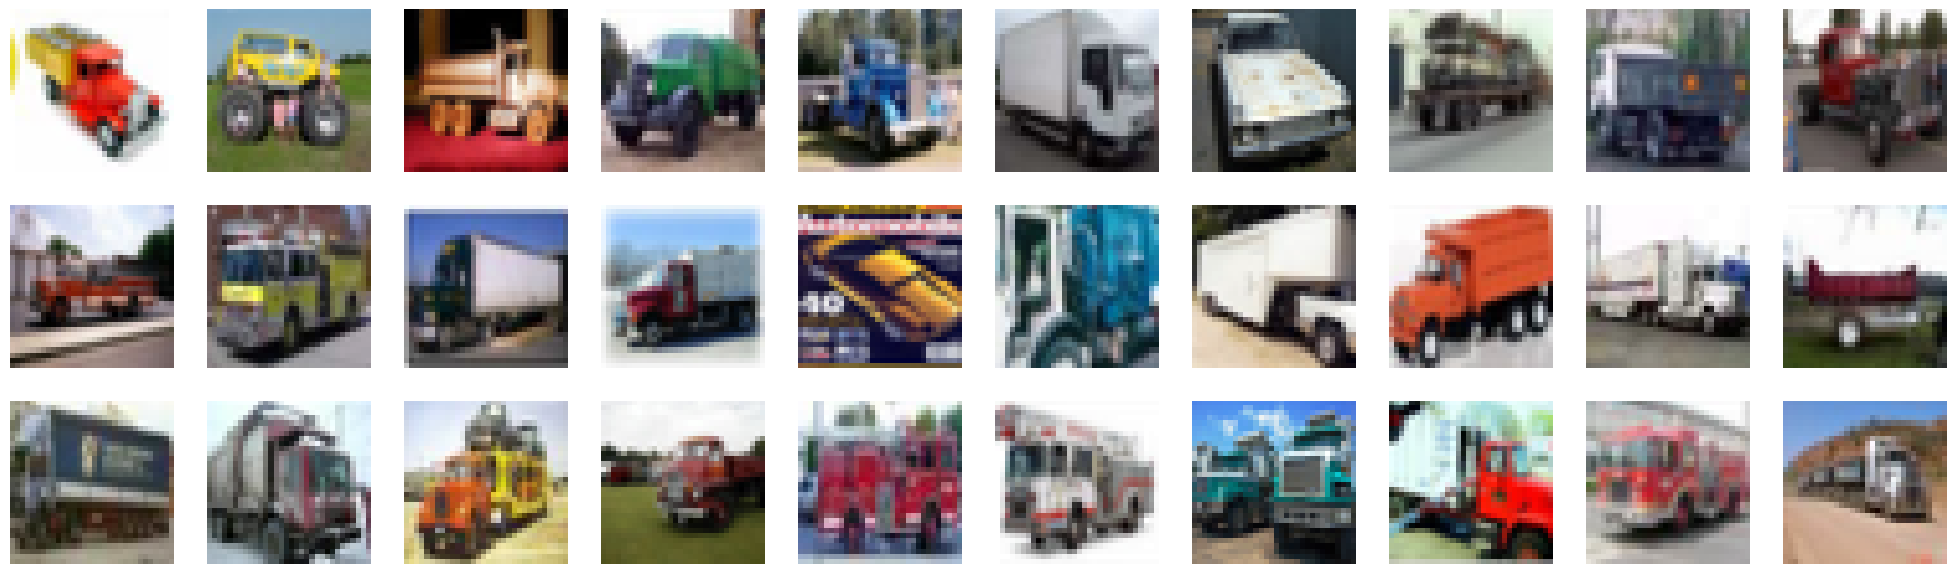

<Figure size 640x480 with 0 Axes>

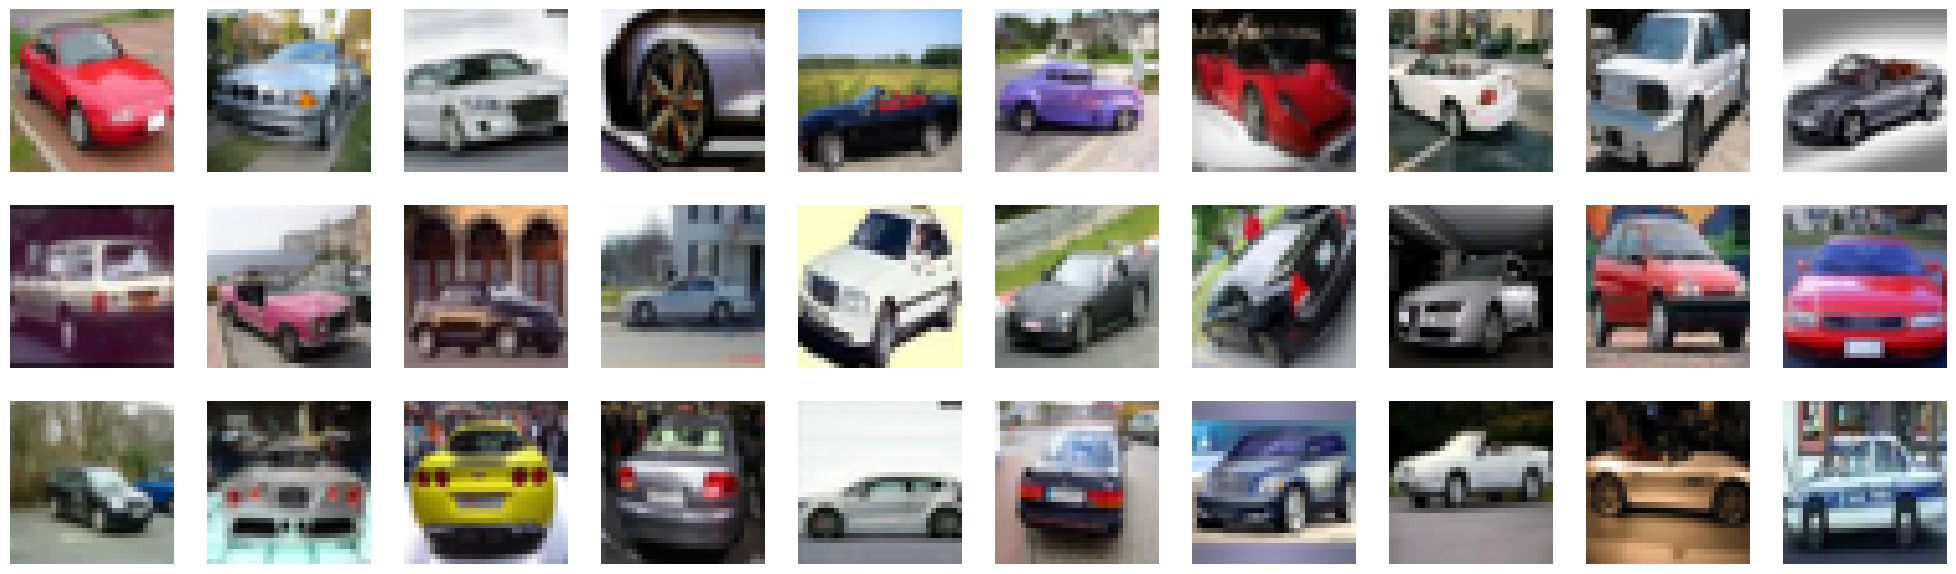

<Figure size 640x480 with 0 Axes>

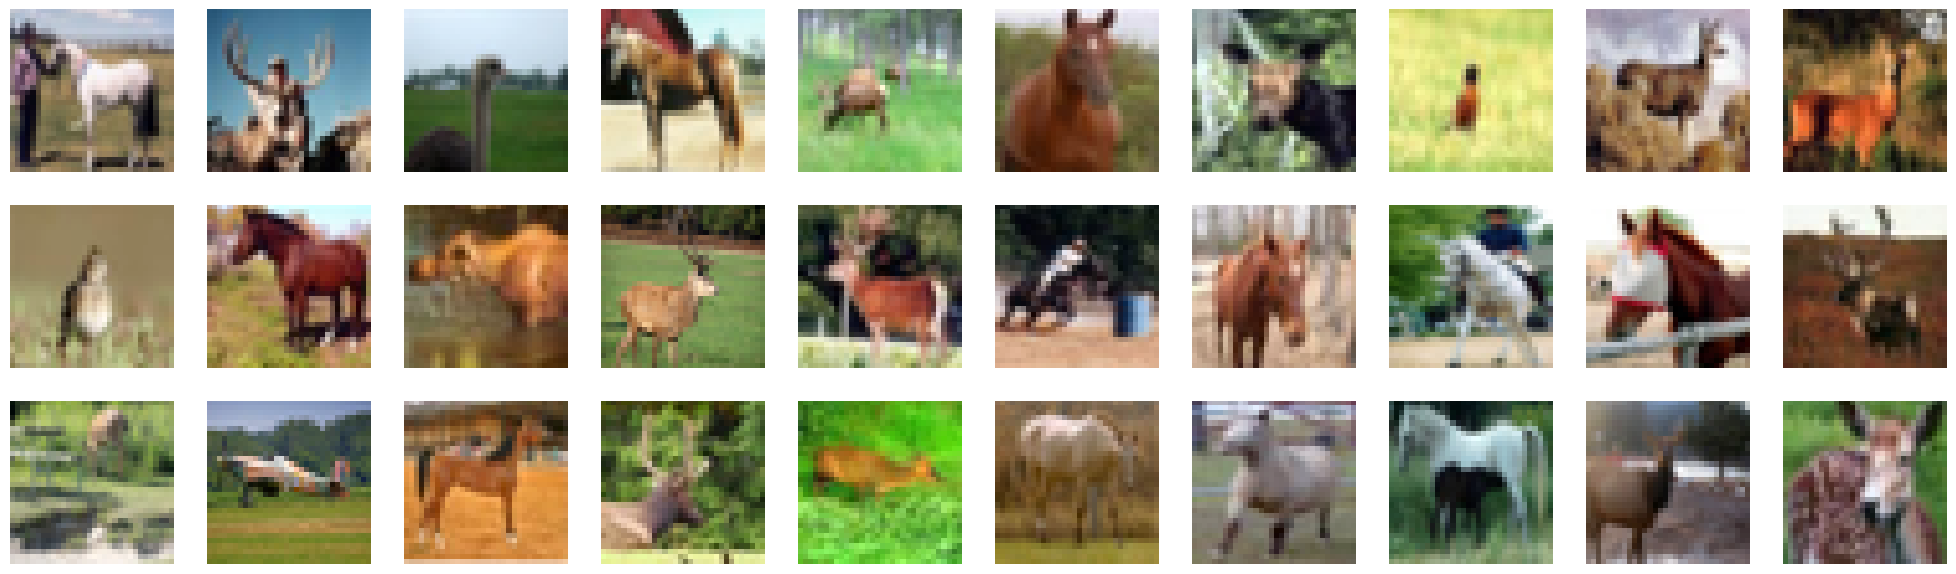

<Figure size 640x480 with 0 Axes>

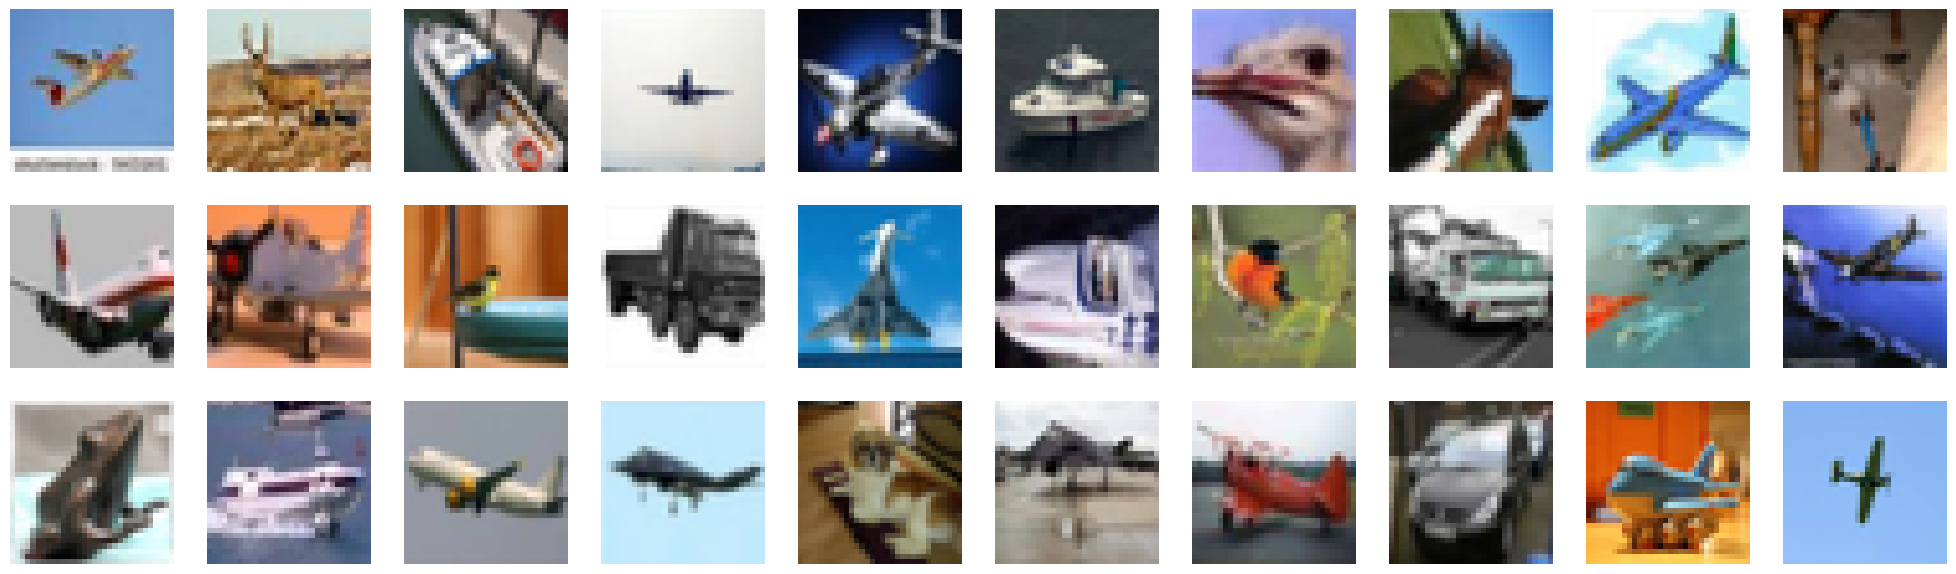

<Figure size 640x480 with 0 Axes>

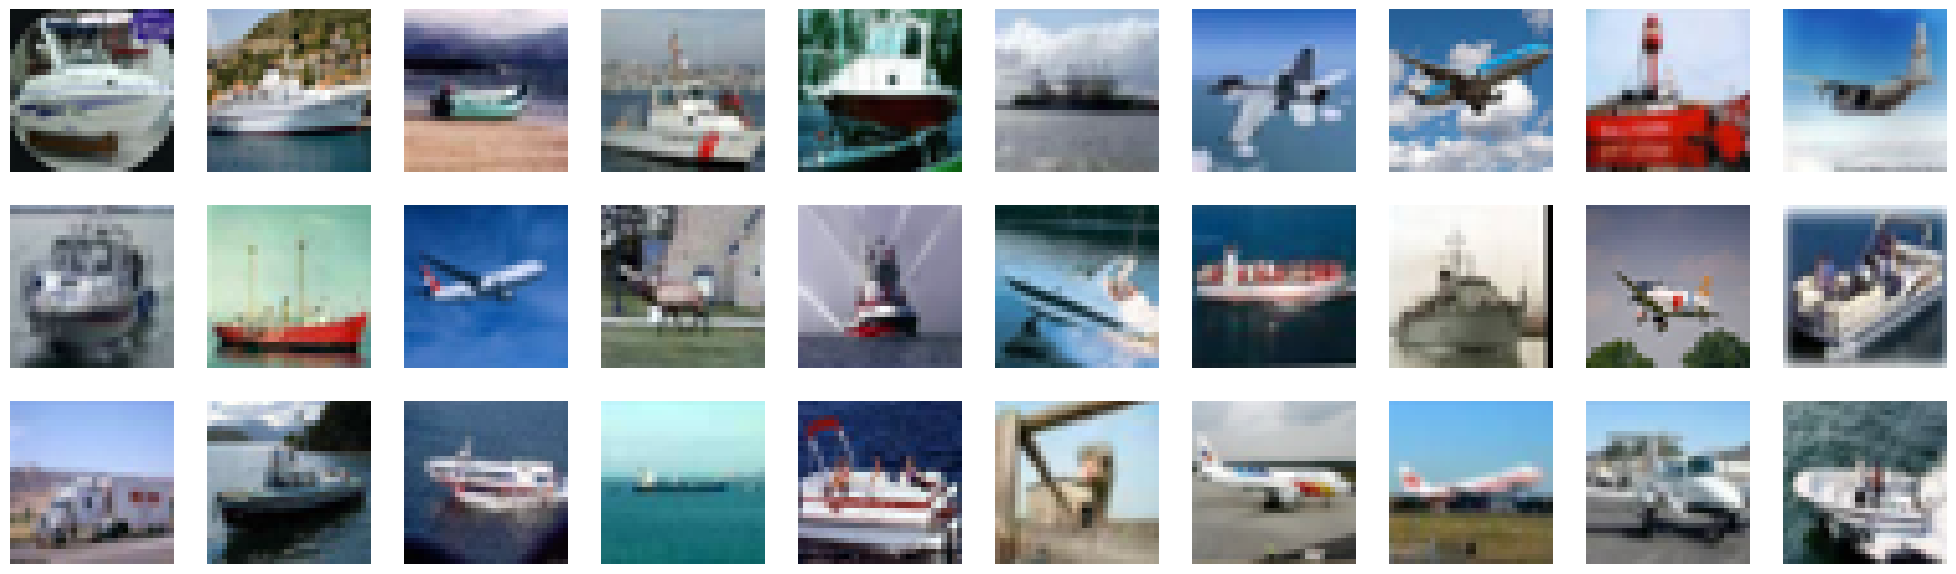

<Figure size 640x480 with 0 Axes>

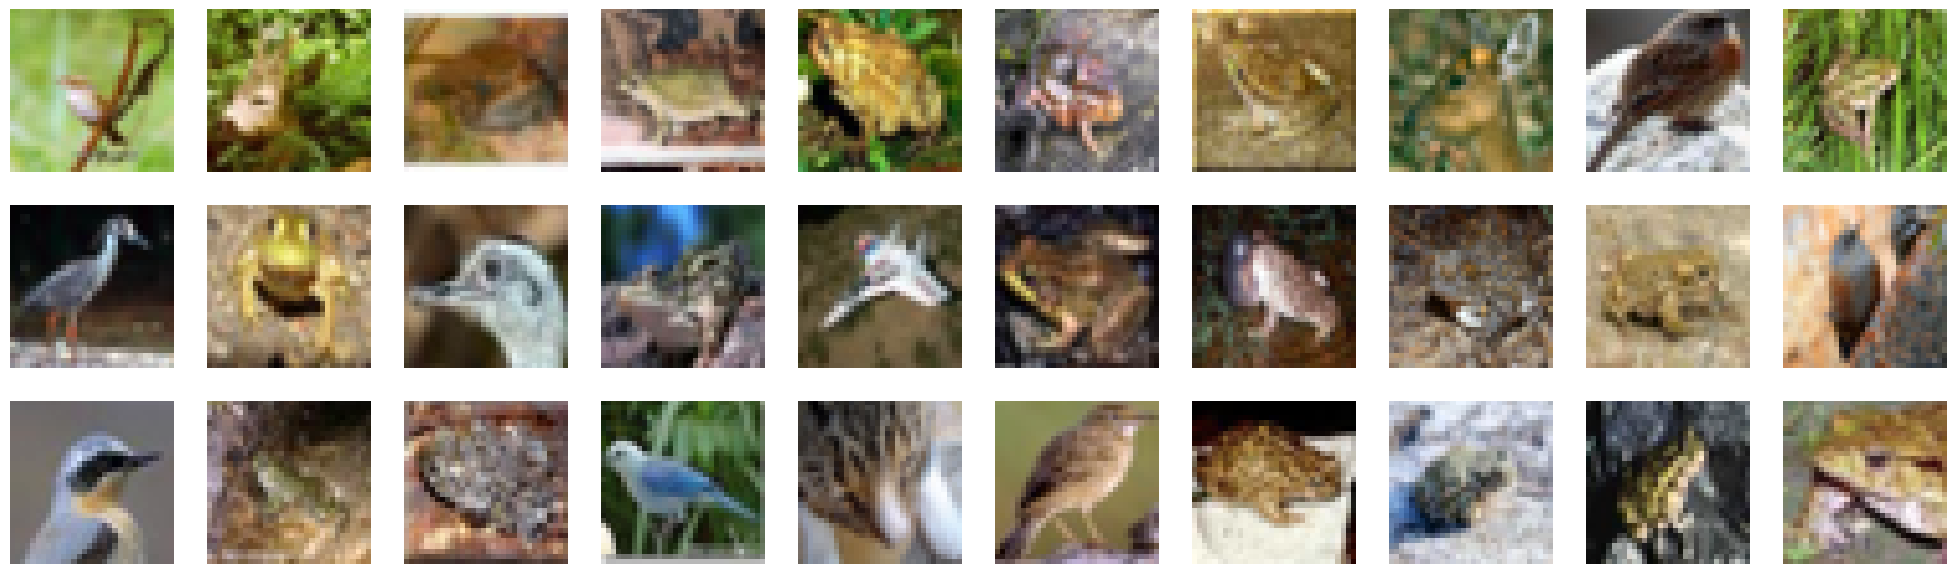

<Figure size 640x480 with 0 Axes>

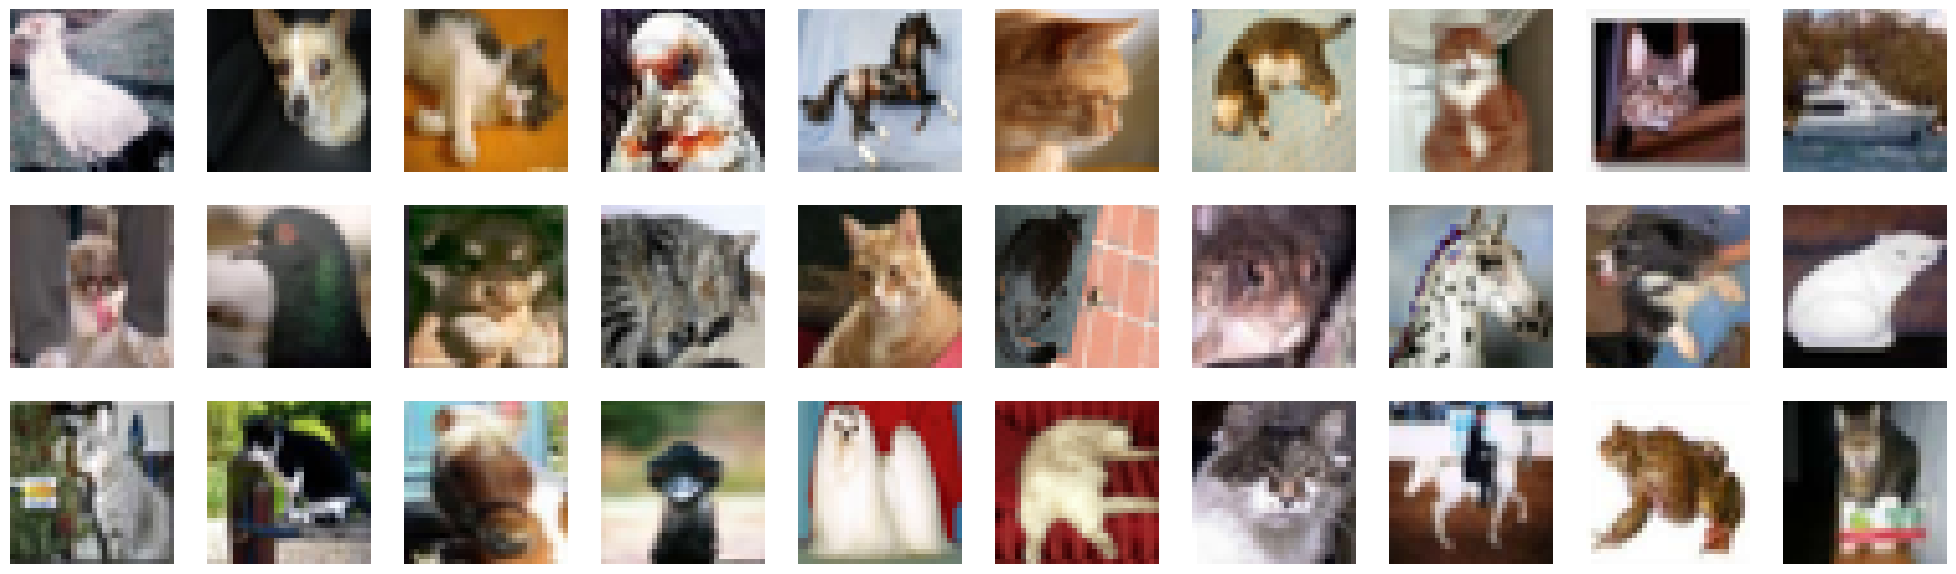

<Figure size 640x480 with 0 Axes>

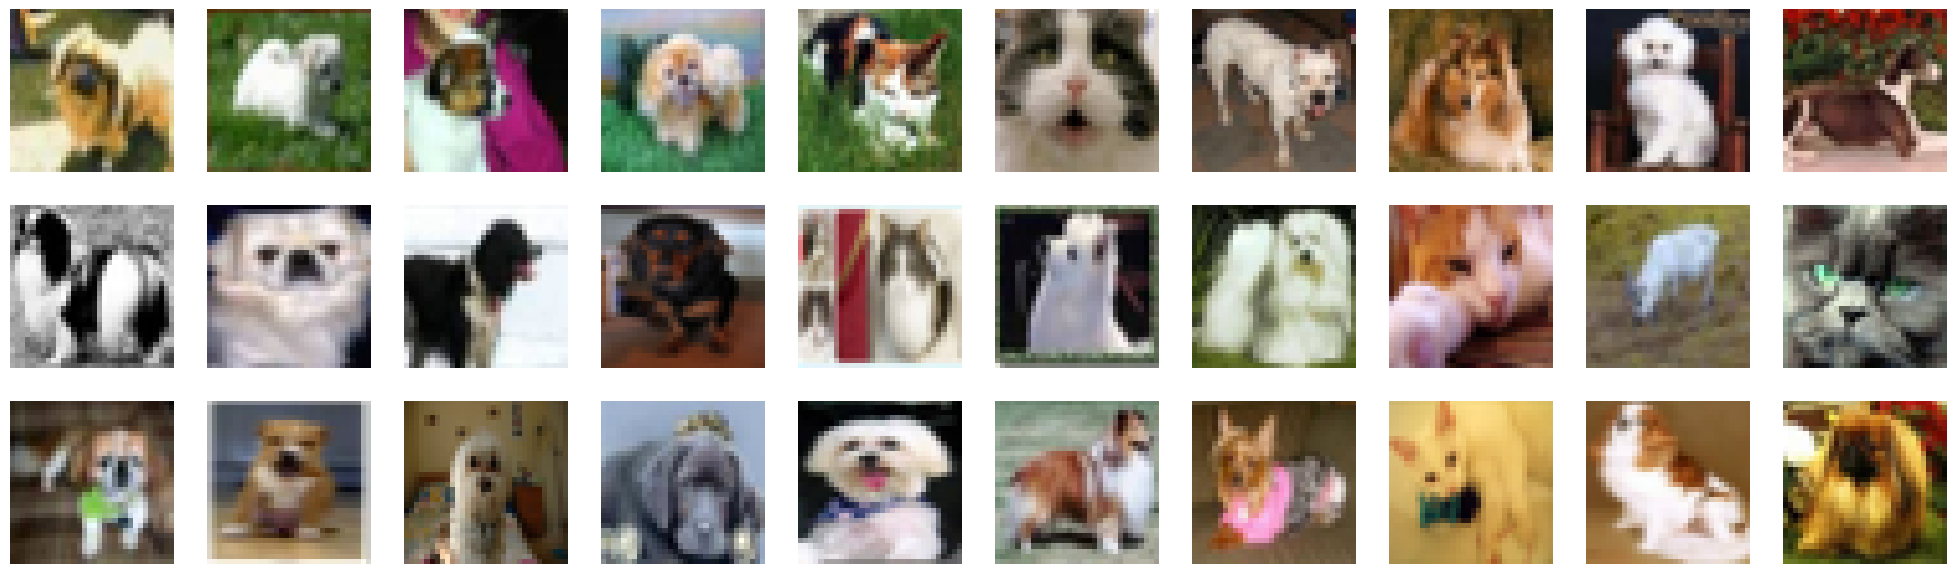

In [21]:
view_clusters(clusters)

Clipping cluster size from 120 to 30


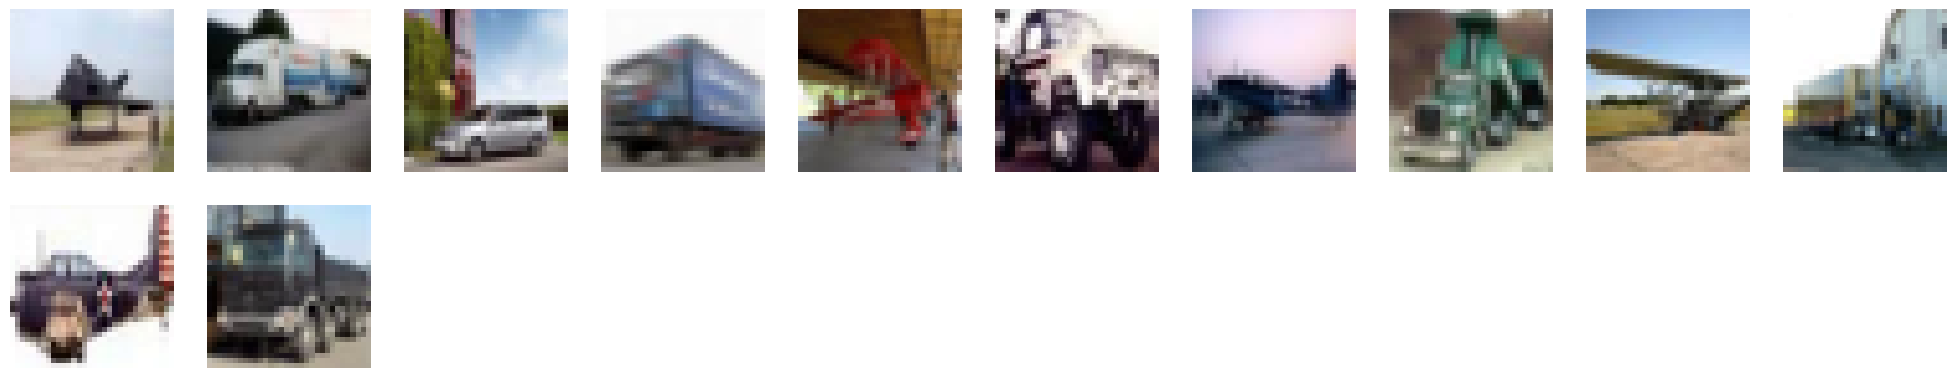

<Figure size 640x480 with 0 Axes>

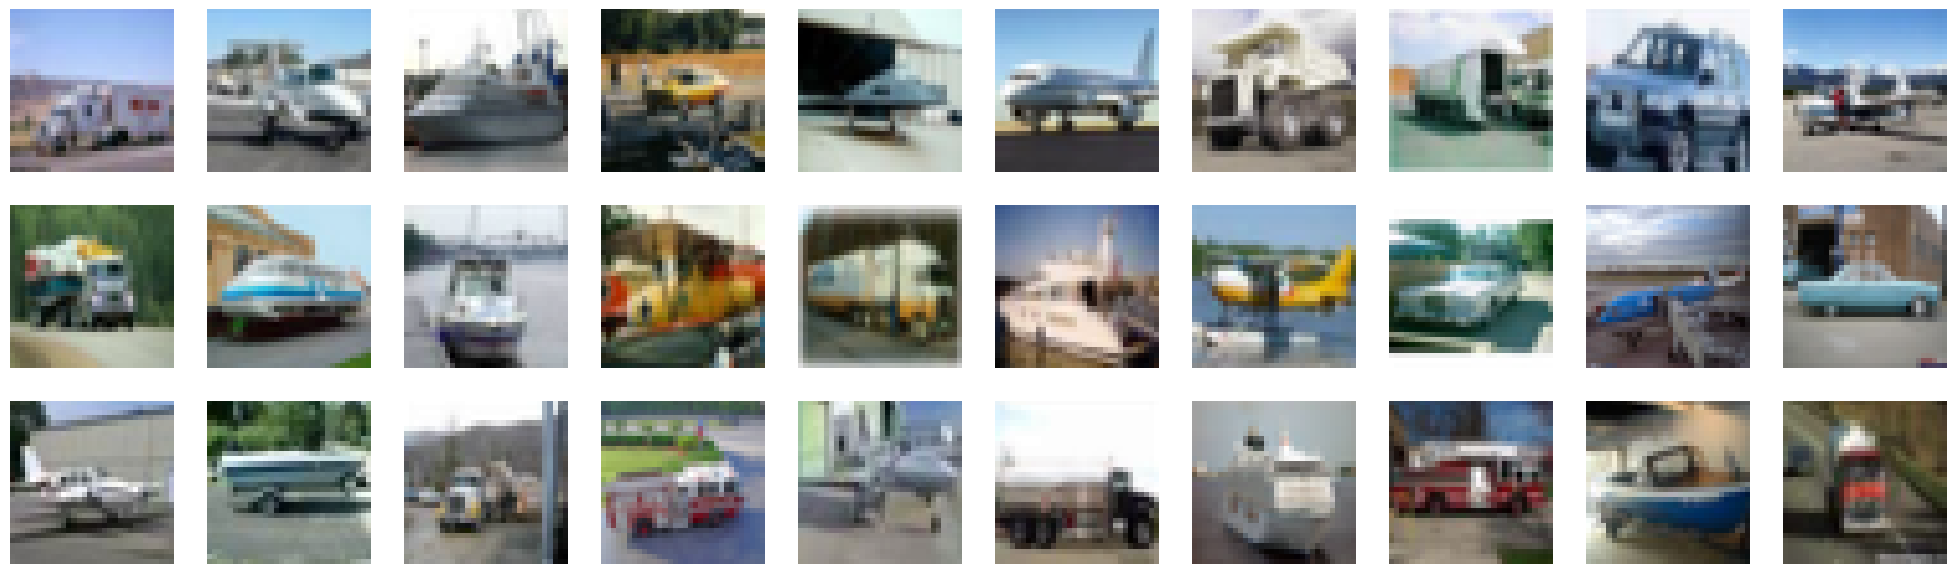

In [22]:
view_clusters(grouped_lists)